In [1]:
from keras import layers
from keras.models import Model, model_from_json
from keras import backend as K

In [1]:
%matplotlib inline
def get_model_results(history):
    from matplotlib import pylab as plt
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = [i for i in range(1,len(acc)+1)]
    print(('acc = %0.2f, loss = %0.2f ')%(max(acc),min(loss)))
    print(('val_acc = %0.2f, val_loss = %0.2f ')%(max(val_acc),min(val_loss)))
    
    plt.figure()
    plt.plot(epochs,acc,'bo',label = 'Training acc')
    plt.plot(epochs,val_acc,'b',label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'bo',label = 'Training loss')
    plt.plot(epochs,val_loss,'b',label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [3]:
def saving_model_into_disk(model, name = 'model'):
    # serialize model to JSON
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name+".h5")
    print("Saved %s to disk"%name)

def load_model_from_disk(name = 'model'):
    # load json and create model
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name+".h5")
    print("Loaded model from disk")
    return loaded_model    

## Preprocessing data

### Loading  twitter data

In [61]:
from pandas import read_csv, Series

In [62]:
df_twits = read_csv('../datasets/sentimenttwits/training.1600000.processed.noemoticon.csv',
                    names = ['sentiment','text'],
                    usecols = [0,5],
                    encoding = 'latin-1')

In [63]:
df_twits.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [64]:
df_twits.drop_duplicates(inplace=True)

In [65]:
def my_tokenizer(s0):
    import re
    from nltk.tokenize import TweetTokenizer

    tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    s0 = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",s0)
    return tknzr.tokenize(s0)

In [66]:
list_of_lengths = [ len(my_tokenizer(s0)) for s0 in df_twits.text.tolist() ]

<IPython.core.display.Javascript object>


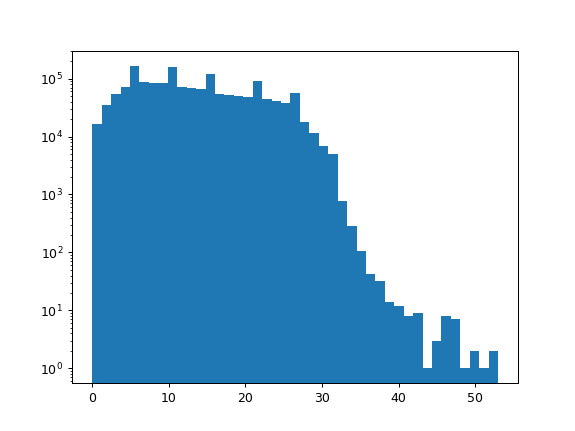

(array([1.66260e+04, 3.50260e+04, 5.38100e+04, 7.27450e+04, 1.65139e+05,
        8.59030e+04, 8.52790e+04, 8.26140e+04, 1.57386e+05, 7.27740e+04,
        6.90890e+04, 6.51900e+04, 1.19539e+05, 5.48260e+04, 5.21880e+04,
        4.99300e+04, 4.79210e+04, 9.26480e+04, 4.39360e+04, 4.11240e+04,
        3.74500e+04, 5.69360e+04, 1.75170e+04, 1.13110e+04, 6.76500e+03,
        5.02200e+03, 7.67000e+02, 2.90000e+02, 1.06000e+02, 4.30000e+01,
        3.20000e+01, 1.40000e+01, 1.20000e+01, 8.00000e+00, 9.00000e+00,
        1.00000e+00, 3.00000e+00, 8.00000e+00, 7.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([ 0.        ,  1.23255814,  2.46511628,  3.69767442,  4.93023256,
         6.1627907 ,  7.39534884,  8.62790698,  9.86046512, 11.09302326,
        12.3255814 , 13.55813953, 14.79069767, 16.02325581, 17.25581395,
        18.48837209, 19.72093023, 20.95348837, 22.18604651, 23.41860465,
        24.65116279, 25.88372093, 27.11627907, 28.34883721, 29.58139535,
  

In [46]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.hist(list_of_lengths,bins=43, log = True)

In [84]:
## Setting text hyperparametters
maxlen = 32
max_words = 100000 # Here I changed it

In [68]:
## Defined cleaned text
df_twits['text_cleaned'] = df_twits.text.map(lambda s: ' '.join(my_tokenizer(s)))

In [69]:
df_twits.head()

,sentiment,text,text_cleaned
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that s a bummer you shoulda got david car...
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i h...


In [70]:
labels = df_twits.sentiment.map(lambda x: int(x/4)).tolist()
texts = df_twits.text_cleaned.tolist()

In [71]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [85]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [86]:
word_index = tokenizer.word_index

### Embedding

In [74]:
import os
from numpy import asarray,zeros

In [95]:
glove_dir = "/home/omar/Documents/DataScience/TextML/embeddings"

embeddings_index = {}
f = open(os.path.join(glove_dir,'glove.6B.300d.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = asarray(values[1:], dtype = 'float32')
    except ValueError:
        print(values[1:])
    embeddings_index[word] = coefs
f.close()
print('Found %d word vectors'%len(embeddings_index))

embedding_dim = 300
embedding_matrix = zeros((max_words,embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors


In [96]:
embedding_matrix.shape

(100000, 300)

In [97]:
## save embedding matrix
import h5py
file_emb_mat = h5py.File('embedding_matrix_'+str(max_words)+'_'+str(embedding_dim)+'_twitter.h5')
file_emb_mat.create_dataset('embedding_matrix',data=embedding_matrix)
file_emb_mat.close()

In [13]:
### Loading Embedded File from h5
import h5py
h5_embedded = h5py.File('embedding_matrix_twitter.h5','r')
embedding_matrix = h5_embedded['embedding_matrix'][:]
h5_embedded.close()

embedding_dim = embedding_matrix.shape[1]

### Preparing Training, Validattion and Test Datasets

In [5]:
from numpy import random
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [98]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = asarray(labels)

#training_samples = 100000
#validation_samples = 10000

In [102]:
data.shape

(1583691, 32)

In [103]:
## save data matrix
import h5py
file_data_twitter = h5py.File('data_twitter_'+str(maxlen)+'.h5')
file_data_twitter.create_dataset('data',data=data)
file_data_twitter.create_dataset('labels',data=labels)
file_data_twitter.close()

In [6]:
## Reading database from twitter to train
h5_data_twitter = h5py.File('data_twitter.h5','r')
data = h5_data_twitter['data'][:]
labels = h5_data_twitter['labels'][:]
h5_data_twitter.close()

training_samples = 100000
validation_samples = 10000

## Setting text hyperparametters
maxlen = 32
max_words = 10000

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(data,labels,
                                                  test_size = validation_samples,
                                                  train_size = training_samples,
                                                  random_state = 1234,
                                                  shuffle = True,
                                                  stratify = labels)Writing

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data,labels,
                                                  test_size=0.1,
                                                  #train_size = 0.8,
                                                  random_state = 1234,
                                                  shuffle = True,
                                                  stratify = labels)

## First Model

In [14]:
def first_model():
    input_twitts = layers.Input(shape = (maxlen,),dtype='int32',name = 'input_twitt')
    emb_dense = layers.Embedding(embedding_matrix.shape[0],
                                 embedding_matrix.shape[1],
                                 input_length=maxlen,
                                 trainable = False,
                                 weights = [embedding_matrix],
                                 mask_zero = True,
                                 name = 'embedded')(input_twitts)

    emb_dense = layers.TimeDistributed(layers.Dense(32, use_bias=False, name = 'emb_dense'),
                                      name = 'time_distributed')(emb_dense)

    layer_gru = layers.GRU(32,
                           dropout = 0.1,
                           recurrent_dropout=0.5,
                           return_sequences=True,
                           use_bias=True,
                           name = 'layer_gru')

    emb_dense = layers.Bidirectional(layer_gru, name = 'bidirectional')(emb_dense)

    emb_dense = layers.GRU(32,
                           dropout = 0.1,
                           recurrent_dropout=0.5,
                           return_sequences=False,
                           use_bias=True,
                           name = 'layer_gru1')(emb_dense)

    emb_dense = layers.Dense(1,activation='relu', use_bias=True, name = 'dense_final')(emb_dense)
    model_twitter = Model(input_twitts, emb_dense)
    model_twitter.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics = ['acc'])
    
    return model_twitter


model_twitter = first_model()

In [314]:
model_twitter.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_twitt (InputLayer)     (None, 32)                0         
_________________________________________________________________
embedded (Embedding)         (None, 32, 100)           1000000   
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 32)            3200      
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 64)            12480     
_________________________________________________________________
layer_gru1 (GRU)             (None, 32)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,025,025
Trainable params: 25,025
Non-trainable params: 1,000,000
_____________________________________________________________

In [338]:
history_big_model = model_twitter.fit(X_train,
                    Y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data=(X_val,Y_val),
                    verbose=False)

acc = 0.78, loss = 0.48 
val_acc = 0.79, val_loss = 0.45 


<IPython.core.display.Javascript object>


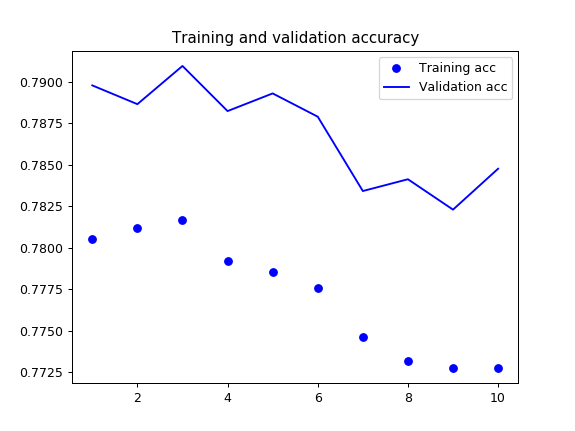

<IPython.core.display.Javascript object>


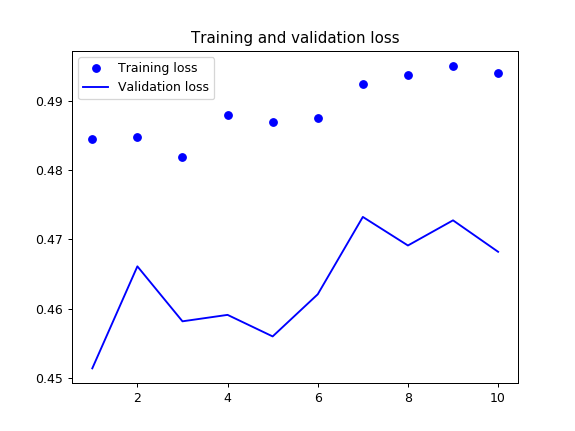

In [339]:
get_model_results(history_big_model)

In [335]:
history = model_twitter.fit(X_train,
                    Y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data=(X_val,Y_val),
                    verbose=False)

acc = 0.78, loss = 0.48 
val_acc = 0.78, val_loss = 0.47 


<IPython.core.display.Javascript object>


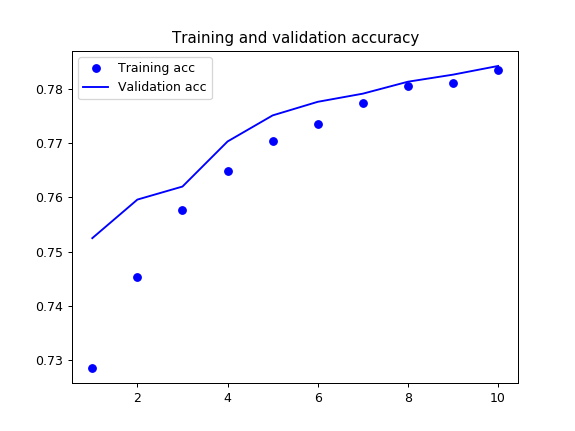

<IPython.core.display.Javascript object>


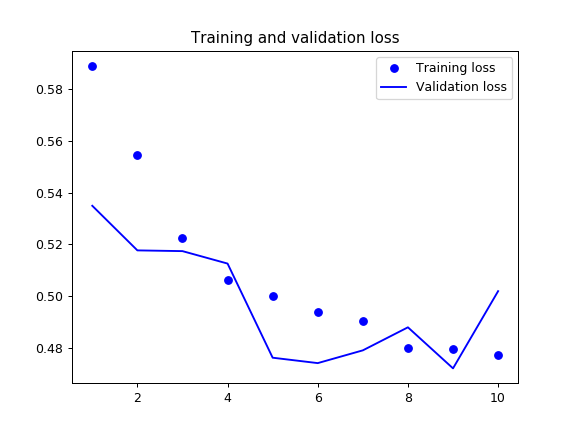

In [336]:
get_model_results(history)

acc = 0.73, loss = 0.57 
val_acc = 0.74, val_loss = 0.57 


<IPython.core.display.Javascript object>


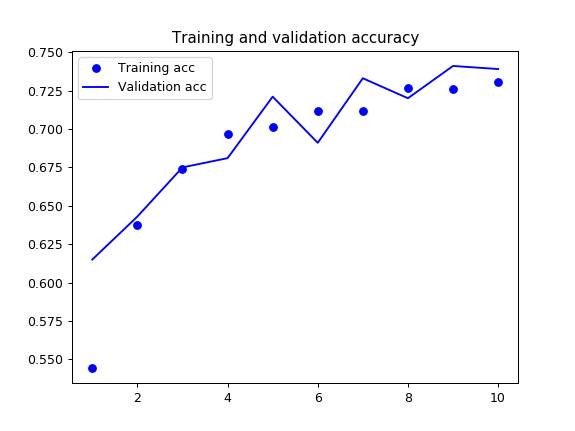

<IPython.core.display.Javascript object>


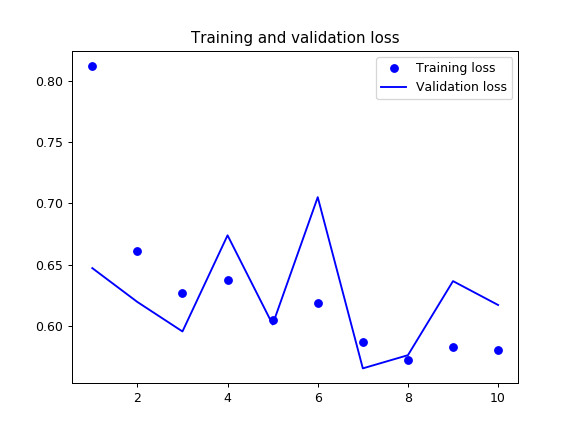

In [331]:
get_model_results(history)
# with a trining set of 10000, validation test 1000
#acc = 0.73, loss = 0.57 
#val_acc = 0.74, val_loss = 0.57 

### With conv nets

In [9]:
from keras import layers
from keras.models import Model

In [23]:
def model_twitter_convnet():
    input_twitter = layers.Input(shape = (maxlen,),dtype='int32',name = 'input_twitter')
    x = layers.Embedding(embedding_matrix.shape[0],
                         embedding_matrix.shape[1],
                         input_length=maxlen,
                         trainable = False,
                         weights = [embedding_matrix],
                         mask_zero = False,
                         name = 'embedded')(input_twitter)

    x = layers.Conv1D(32,5,activation='relu', name = 'conv1d_1')(x)
    x = layers.MaxPool1D(3, name = 'maxpool_1')(x)
    x = layers.Dropout(0.5, name = 'dropout_1')(x)

    x = layers.Conv1D(32,5,activation='relu', name = 'conv1d_2')(x)
    x = layers.MaxPool1D(3, name = 'maxpool_2')(x)
    x = layers.Dropout(0.5, name = 'dropout_2')(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, name = 'dense_final')(x)

    conv_gru_model = Model(input_twitter,x)
    conv_gru_model.compile(optimizer='rmsprop',
                           loss='binary_crossentropy',
                           metrics = ['acc'])
    return conv_gru_model


def model_twitter_convnet_gru():
    input_twitter = layers.Input(shape = (maxlen,), dtype='int32', name = 'input_twitter')
    x = layers.Embedding(embedding_matrix.shape[0],
                         embedding_matrix.shape[1],
                         input_length=maxlen,
                         trainable = False,
                         weights = [embedding_matrix],
                         mask_zero = False,
                         name = 'embedded')(input_twitter)

    x = layers.Conv1D(32,5,activation='relu', name = 'conv1d_1')(x)
    x = layers.MaxPool1D(3, name = 'maxpool_1')(x)
    x = layers.Dropout(0.5, name = 'dropout_1')(x)

    x = layers.Conv1D(32,5,activation='relu', name = 'conv1d_2')(x)
    x = layers.MaxPool1D(3, name = 'maxpool_2')(x)
    x = layers.Dropout(0.5, name = 'dropout_2')(x)

    layer_gru = layers.GRU(32,dropout=0.1,recurrent_dropout=0.5, name = 'gru')
    x = layers.Bidirectional(layer_gru, name = 'bidirectional')(x)
    
    x = layers.Dense(1, name = 'dense_final')(x)

    conv_gru_model = Model(input_twitter,x)
    conv_gru_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
    return conv_gru_model


def model_twitter_convnet_td():
    input_twitter = layers.Input(shape = (maxlen,),dtype='int32',name = 'input_twitter')
    x = layers.Embedding(embedding_matrix.shape[0],
                         embedding_matrix.shape[1],
                         input_length=maxlen,
                         trainable = True,
                         weights = [embedding_matrix],
                         mask_zero = False,
                         name = 'embedded')(input_twitter)

    x = layers.Conv1D(32,(5),padding='same',kernel_initializer='orthogonal',name = 'conv1d_1')(x)
    x = layers.Activation('elu', name = 'act_elu_1')(x)
    x = layers.MaxPool1D(3, name = 'maxpool_1')(x)
    x = layers.Dropout(0.2, name = 'dropout_1')(x)

    x = layers.Conv1D(32,(5),padding='same',kernel_initializer='orthogonal',name = 'conv1d_2')(x)
    x = layers.Activation('elu', name = 'act_elu_2')(x)
    x = layers.MaxPool1D(3, name = 'maxpool_2')(x)
    x = layers.Dropout(0.2, name = 'dropout_2')(x)
    
    x = layers.Bidirectional(layers.LSTM(32,
                                         return_sequences=True,
                                         kernel_initializer='orthogonal',
                                         name = 'lstm_1'))(x)
    x = layers.Activation('elu', name = 'act_elu_3')(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=False,
                                         kernel_initializer='orthogonal',
                                         name = 'lstm_2'))(x)
    x = layers.Activation('elu', name = 'act_elu_4')(x)
    
    x = layers.Dense(1, name = 'dense_final')(x)
    
    model = Model(input_twitter,x)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['acc'])
    return model


#conv_model = model_twitter_convnet()
#convnet_gru_model = model_twitter_convnet_gru()
convnet_td = model_twitter_convnet_td()

In [24]:
convnet_td.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_twitter (InputLayer)   (None, 32)                0         
_________________________________________________________________
embedded (Embedding)         (None, 32, 100)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 32)            16032     
_________________________________________________________________
act_elu_1 (Activation)       (None, 32, 32)            0         
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 10, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 32)            5152      
__________

In [25]:
hist_convnet_td = convnet_td.fit(X_train,
                                 Y_train,
                                 epochs = 10,
                                 batch_size = 32,
                                 validation_data=(X_val,Y_val),
                                 verbose=False)

In [28]:
scores = convnet_td.evaluate(X_val, Y_val, verbose=True)

158370/158370 [==============================] - 49s 312us/step


In [57]:
#str_model = convnet_td
#dict(name,eval(convnet_td))
#[k for k,v in locals() ]

acc = 0.50, loss = 8.08 
val_acc = 0.50, val_loss = 8.08 


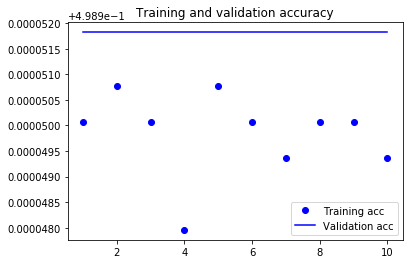

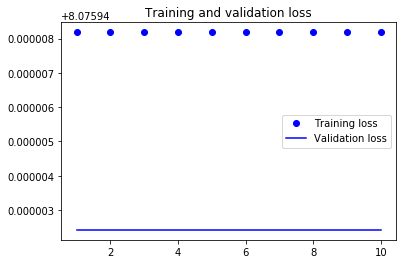

In [30]:
get_model_results(hist_convnet_td)
#acc = 0.78, loss = 0.47 
#val_acc = 0.79, val_loss = 0.45 

### conv model

In [67]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_twitter (InputLayer)   (None, 32)                0         
_________________________________________________________________
embedded (Embedding)         (None, 32, 100)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            32064     
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 9, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 64)             20544     
_________________________________________________________________
maxpool_2 (MaxPooling1D)     (None, 1, 64)             0         
__________

In [68]:
hist_conv_model = conv_model.fit(X_train,
                                 Y_train,
                                 epochs = 10,
                                 batch_size = 32,
                                 validation_data=(X_val,Y_val),
                                 verbose=False)

acc = 0.58, loss = 0.76 
val_acc = 0.61, val_loss = 0.67 


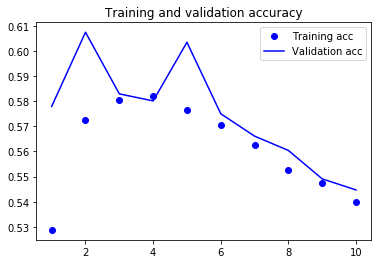

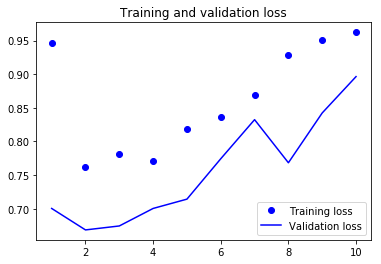

In [69]:
get_model_results(hist_conv_model)

### Second attempt

In [61]:
convnet_gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_twitter (InputLayer)   (None, 32)                0         
_________________________________________________________________
embedded (Embedding)         (None, 32, 100)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 32)            16032     
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 9, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             5152      
_________________________________________________________________
maxpool_2 (MaxPooling1D)     (None, 1, 32)             0         
__________

In [51]:
hist_conv_gru_model = conv_gru_model.fit(X_train,
                                         Y_train,
                                         epochs = 10,
                                         batch_size = 32,
                                         validation_data=(X_val,Y_val),
                                         verbose=False)

acc = 0.65, loss = 0.62 
val_acc = 0.63, val_loss = 0.64 


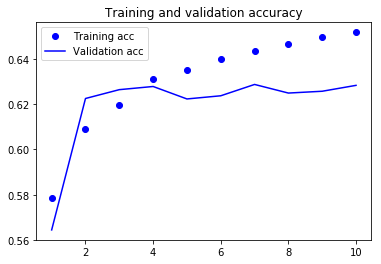

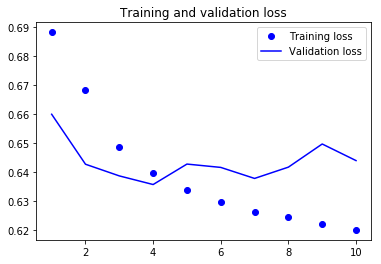

In [52]:
get_model_results(hist_conv_gru_model)

### First attempt

In [37]:
hist_conv_gru_model = conv_gru_model.fit(X_train,
                                         Y_train,
                                         epochs = 10,
                                         batch_size = 32,
                                         validation_data=(X_val,Y_val),
                                         verbose=False)

acc = 0.67, loss = 0.60 
val_acc = 0.63, val_loss = 0.64 


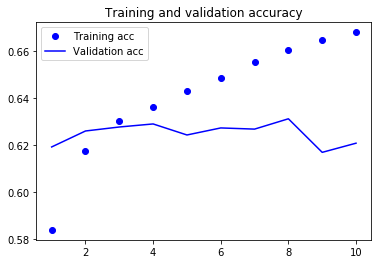

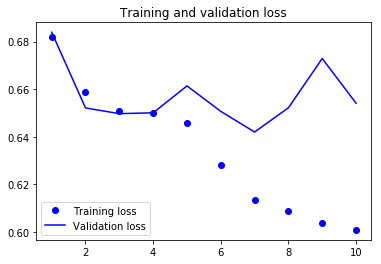

In [41]:
## Without dropout and one lstm with one direcction. Dropout sonly within the lstm
get_model_results(hist_conv_gru_model)

#### example